# Segmenting and Clustering Neighborhoods in Toronto

## Part 1: Building the Data Frame

### Installing and importing libraries (I am not sure which ones I will need yet, so let's get several!!)

In [1]:
import requests 
import pandas as pd 
import numpy as np 
import random 

# module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 


from IPython.display import display_html

# tranforming json file into a pandas dataframe
from pandas.io.json import json_normalize

# plotting library
!pip install folium
import folium 

from bs4 import BeautifulSoup
from sklearn.cluster import KMeans

#Matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors


### Scraping Wikipedia page for data

In [2]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source, 'lxml')

table = soup.find("table")
table_rows = table.tbody.find_all("tr")

res = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    
    # Ignore rows with no borough
    if row != [] and row[1] != "Not assigned\n":
        # If a cell has a borough but no neighborhood, then the neighborhood will be the same as the borough.
        if "Not assigned\n" in row[2]: 
            row[2] = row[1]
        res.append(row)

# Dataframe with 3 columns
pd.set_option("display.max_rows", None, "display.max_columns", None)
df = pd.DataFrame(res, columns = ["PostalCode", "Borough", "Neighborhood"])
df.head()

,PostalCode,Borough,Neighborhood
0,M3A\n,North York\n,Parkwoods\n
1,M4A\n,North York\n,Victoria Village\n
2,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"
3,M6A\n,North York\n,"Lawrence Manor, Lawrence Heights\n"
4,M7A\n,Downtown Toronto\n,"Queen's Park, Ontario Provincial Government\n"


In [3]:
#I have no idea why everything is ending with \n, but let's fix that
df["Neighborhood"] = df["Neighborhood"].str.replace("\n","")
df["Borough"] = df["Borough"].str.replace("\n","")
df["PostalCode"] = df["PostalCode"].str.replace("\n","")
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [4]:
df = df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(", ".join).reset_index()
df.shape

(103, 3)

## Part 2: Latitudes and Longitudes

### Find coordinates (using the csv link because it is a lot easier that way)

In [5]:
df2 = pd.read_csv("http://cocl.us/Geospatial_data")
df2

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


### Combine the two dataframes (df and df2) into one ULTIMATE dataframe (named df_ultimate, obviously)

In [6]:
df_ultimate = pd.merge(df, df2, how='left', left_on = 'PostalCode', right_on = 'Postal Code')
# remove the 2nd Postal Code column
df_ultimate.drop("Postal Code", axis=1, inplace=True)
df_ultimate.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Part 3: Explore and Cluster the Toronto Neighborhoods

### I like to be able to see my entire dataframe at least once, so I'm going to print the entire thing


In [7]:
df_ultimate

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


### Find Coordinates of Toronto

In [8]:
address = "Toronto, ON"

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Coordinates of Toronto city are: {}, {}.'.format(latitude, longitude))

Coordinates of Toronto city are: 43.6534817, -79.3839347.


### Create the Toronto Map

#### IN CASE THE MAP WON'T LOAD FOR YOU, HERE'S A SCREENSHOT OF IT: https://github.com/rb2925a/Coursera_Capstone/blob/main/TorontoMap1.png



In [9]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
map_toronto

### Add Markers to Map of Toronto

#### IN CASE THE MAP WON'T LOAD FOR YOU, HERE'S A SCREENSHOT OF IT: https://github.com/rb2925a/Coursera_Capstone/blob/main/TorontoMap2.png

In [10]:
for lat, lng, borough, neighborhood in zip(
        df_ultimate['Latitude'], 
        df_ultimate['Longitude'], 
        df_ultimate['Borough'], 
        df_ultimate['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto


### Focus only on the Toronto boroughs (East, North, Central, & Downtown)

In [11]:
df_ultimate_toronto = df_ultimate[df_ultimate['Borough'].str.contains("Toronto")].reset_index(drop=True)
df_ultimate_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


### Plot the Map again (this time with only the Toronto boroughs!)

#### IN CASE THE MAP WON'T LOAD FOR YOU, HERE'S A SCREENSHOT OF IT: https://github.com/rb2925a/Coursera_Capstone/blob/main/TorontoMap3.png

In [13]:


map_ultimate_toronto = folium.Map(location=[latitude, longitude], zoom_start=12.5)
for lat, lng, borough, neighborhood in zip(
        df_ultimate_toronto['Latitude'], 
        df_ultimate_toronto['Longitude'], 
        df_ultimate_toronto['Borough'], 
        df_ultimate_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ultimate_toronto)  

map_ultimate_toronto



### Foursquare Credentials (leaving this blank because that seems like the smart thing to do)

In [14]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20201112'



### Explore 1st Neighborhood

In [15]:
neighborhood_name = df_ultimate_toronto.loc[0, 'Neighborhood']
print(f"First neighborhood's name is: '{neighborhood_name}'.")

First neighborhood's name is: 'The Beaches'.


### Find Coordinates of "The Beaches"

In [16]:
neighborhood_latitude = df_ultimate_toronto.loc[0, 'Latitude']
neighborhood_longitude = df_ultimate_toronto.loc[0, 'Longitude'] 

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


Find Top 100 Venues within 500 Mile Radius of "The Beaches"

In [17]:
LIMIT = 100 
radius = 500 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()



### Extract Venue Categories

In [18]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']



### Convert the JSON into a pd df

In [19]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app


,name,categories,lat,lng
0,Glen Manor Ravine,Trail,43.676821,-79.293942
1,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
2,Grover Pub and Grub,Pub,43.679181,-79.297215
3,Upper Beaches,Neighborhood,43.680563,-79.292869


### Now do what we did with "The Beaches" except with every other neighborhood
#### Note: I went with a 400 mile radius instead of 500 because 500 kept giving me an error for some reason

In [65]:
def getNearbyVenues(names, latitudes, longitudes, radius=400):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



In [66]:
toronto_venues = getNearbyVenues(names=df_ultimate_toronto['Neighborhood'],
                                   latitudes=df_ultimate_toronto['Latitude'],
                                   longitudes=df_ultimate_toronto['Longitude']
                                  )

In [67]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant
2,"The Danforth West, Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop
3,"The Danforth West, Riverdale",43.679557,-79.352188,Mezes,43.677962,-79.350196,Greek Restaurant
4,"The Danforth West, Riverdale",43.679557,-79.352188,Cafe Fiorentina,43.677743,-79.350115,Italian Restaurant


### Find number of venues for each Neighborhood!

In [68]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,19,19,19,19,19,19
"Brockton, Parkdale Village, Exhibition Place",16,16,16,16,16,16
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",13,13,13,13,13,13
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",11,11,11,11,11,11
Central Bay Street,75,75,75,75,75,75
Christie,10,10,10,10,10,10
Church and Wellesley,55,55,55,55,55,55
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,26,26,26,26,26,26


In [69]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 207 uniques categories.


### Analyse the Neighborhoods

In [70]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Trail,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health Food Store,History Museum,Hobby Shop,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Group by Neighborhood

In [71]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Trail,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health Food Store,History Museum,Hobby Shop,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.052632,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.052632,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.052632,0.052632,0.00,0.0000,0.00,0.000000,0.00,0.052632,0.000000,0.052632,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.052632,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.052632,0.052632,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.052632,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.052632,0.000000,0

### Find top 3 venues in each Neighborhood

In [72]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Berczy Park,Pharmacy,Sushi Restaurant,Park
1,"Brockton, Parkdale Village, Exhibition Place",Café,Nightclub,Coffee Shop
2,"Business reply mail Processing Centre, South C...",Pizza Place,Garden,Park
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Boutique,Airport Terminal
4,Central Bay Street,Coffee Shop,Sandwich Place,Café
5,Christie,Café,Grocery Store,Coffee Shop
6,Church and Wellesley,Gay Bar,Coffee Shop,Restaurant
7,"Commerce Court, Victoria Hotel",Coffee Shop,Café,Restaurant
8,Davisville,Dessert Shop,Pizza Place,Sandwich Place
9,Davisville North,Gym / Fitness Center,Food & Drink Shop,Breakfast Spot


### K Means Clustering

In [73]:
X = toronto_grouped.drop(['Neighborhood'], axis = 1)
y = toronto_grouped['Neighborhood']
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
#Train Model and Predict
k = 4  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
Pred_y = neigh.predict(X_test)
print("Accuracy of model at K=4 is",metrics.accuracy_score(y_test, Pred_y))

Accuracy of model at K=4 is 0.0


### Find Optimal K

### Finding the K value with the lowest Error Rate

Minimum error:- 1.0 at K = 0


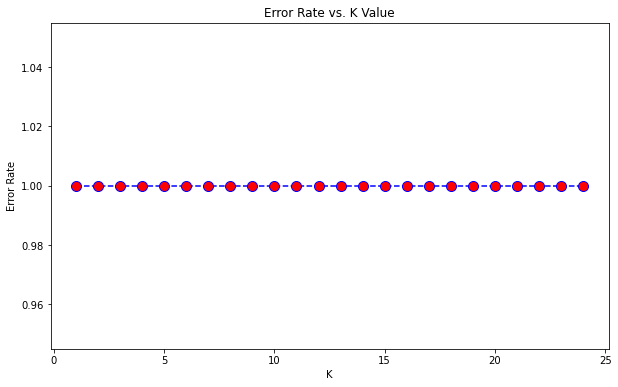

In [78]:
import matplotlib.pyplot as plt
error_rate = []
for i in range(1,25):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,25),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

### Finding K Value with the highest Accuracy

Maximum accuracy:- 0.0 at K = 0


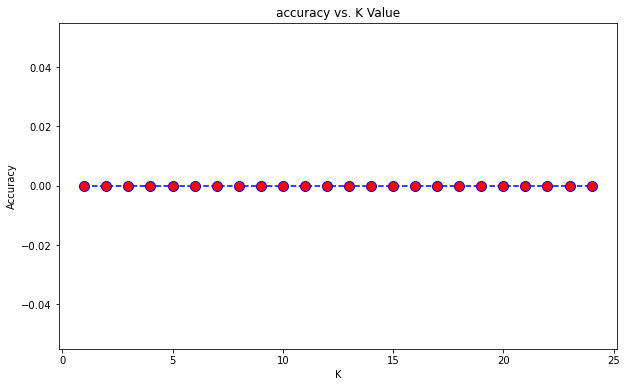

In [77]:
acc = []

from sklearn import metrics
for i in range(1,25):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,25),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

### Turns out that using only a 50 mile radius gives us terrible data for clustering. On the flip side, because the accuracy is 0% for each K value, it doesn't really matter what value we choose. Let's stick to the k=4 I tested before.

In [79]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [133]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster labels', kmeans.labels_)

toronto_merged = df_ultimate_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


In [134]:
toronto_merged

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster labels,Cluster Labels,ClusterLabels,ClusterLabels2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,2.0,2.0,2.0,2.0,Trail,Women's Store,Dim Sum Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1.0,1.0,1.0,1.0,Greek Restaurant,Coffee Shop,Restaurant
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,1.0,1.0,1.0,1.0,Pub,Coffee Shop,Fish & Chips Shop
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1.0,1.0,1.0,1.0,Coffee Shop,Gastropub,Latin American Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,1.0,1.0,1.0,1.0,Gym / Fitness Center,Food & Drink Shop,Breakfast Spot
6,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678,0.0,0.0,0.0,0.0,Park,Women's Store,Dim Sum Restaurant
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,1.0,1.0,1.0,1.0,Dessert Shop,Pizza Place,Sandwich Place
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,2.0,2.0,2.0,2.0,Trail,Women's Store,Dim Sum Restaurant
9,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,1.0,1.0,1.0,1.0,Coffee Shop,Liquor Store,Supermarket


### Creating the final Map

#### Getting rid of the NaN values first

In [139]:
toronto_merged.drop([4, 22 ,35], axis =0, inplace=True)

In [140]:
toronto_merged

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster labels,Cluster Labels,ClusterLabels,ClusterLabels2,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,2.0,2.0,2.0,2.0,Trail,Women's Store,Dim Sum Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1.0,1.0,1.0,1.0,Greek Restaurant,Coffee Shop,Restaurant
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,1.0,1.0,1.0,1.0,Pub,Coffee Shop,Fish & Chips Shop
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1.0,1.0,1.0,1.0,Coffee Shop,Gastropub,Latin American Restaurant
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,1.0,1.0,1.0,1.0,Gym / Fitness Center,Food & Drink Shop,Breakfast Spot
6,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678,0.0,0.0,0.0,0.0,Park,Women's Store,Dim Sum Restaurant
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,1.0,1.0,1.0,1.0,Dessert Shop,Pizza Place,Sandwich Place
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,2.0,2.0,2.0,2.0,Trail,Women's Store,Dim Sum Restaurant
9,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,1.0,1.0,1.0,1.0,Coffee Shop,Liquor Store,Supermarket
10,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,3.0,3.0,3.0,3.0,Playground,Bike Trail,Women's Store


In [141]:
toronto_merged.drop(["Cluster Labels", "ClusterLabels" ,"ClusterLabels2"], axis=1, inplace=True)

In [142]:
 toronto_merged

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,2.0,Trail,Women's Store,Dim Sum Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1.0,Greek Restaurant,Coffee Shop,Restaurant
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,1.0,Pub,Coffee Shop,Fish & Chips Shop
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1.0,Coffee Shop,Gastropub,Latin American Restaurant
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,1.0,Gym / Fitness Center,Food & Drink Shop,Breakfast Spot
6,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678,0.0,Park,Women's Store,Dim Sum Restaurant
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,1.0,Dessert Shop,Pizza Place,Sandwich Place
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,2.0,Trail,Women's Store,Dim Sum Restaurant
9,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,1.0,Coffee Shop,Liquor Store,Supermarket
10,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,3.0,Playground,Bike Trail,Women's Store


### Turning the Clusters column into int.

In [148]:
toronto_merged['Cluster labels'] =toronto_merged['Cluster labels'].astype(int)

### Creating the final map

#### IN CASE THE MAP WON'T LOAD FOR YOU, HERE'S A SCREENSHOT OF IT: https://github.com/rb2925a/Coursera_Capstone/blob/main/TorontoMap4.png

In [149]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        toronto_merged['Latitude'], 
        toronto_merged['Longitude'], 
        toronto_merged['Neighborhood'], 
        toronto_merged['Cluster labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters